## 1. Import Relevant Packages

In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import *
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_theme(style='white', color_codes=True, palette='Blues_r')
plt.rcParams["font.family"] = "Times New Roman"

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

In [2]:
# Loading Pyfolio for results

import pyfolio as pf
%matplotlib inline
import empyrical

# silence warnings
import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
# Other graphs require 'bt_positions' (backtest position) information

In [4]:
# Define start and end periods for results


start = '1931-01-01'
end = '2020-12-31'

#start = '2008-01-01'
#end = '2010-12-30'

#start = '2009-03-09'
#end = '2013-03-28'

## 2. Importing risk free rate

In [5]:
risk_free = pd.read_csv('risk_free_1931.csv', low_memory=False, index_col=0)
risk_free.index = pd.to_datetime(risk_free.index).tz_convert('UTC')
risk_free

,RF
date,
1931-01-02 00:00:00+00:00,0.00006
1931-01-03 00:00:00+00:00,0.00006
1931-01-05 00:00:00+00:00,0.00006
1931-01-06 00:00:00+00:00,0.00006
1931-01-07 00:00:00+00:00,0.00006
...,...
2020-12-24 00:00:00+00:00,0.00000
2020-12-28 00:00:00+00:00,0.00000
2020-12-29 00:00:00+00:00,0.00000


In [6]:
risk_free = risk_free[risk_free.index >= start]
risk_free = risk_free[risk_free.index <= end]

In [7]:
risk_free = risk_free['RF']

In [8]:
risk_free

date
1931-01-02 00:00:00+00:00    0.00006
1931-01-03 00:00:00+00:00    0.00006
1931-01-05 00:00:00+00:00    0.00006
1931-01-06 00:00:00+00:00    0.00006
1931-01-07 00:00:00+00:00    0.00006
                              ...   
2020-12-24 00:00:00+00:00    0.00000
2020-12-28 00:00:00+00:00    0.00000
2020-12-29 00:00:00+00:00    0.00000
2020-12-30 00:00:00+00:00    0.00000
2020-12-31 00:00:00+00:00    0.00000
Name: RF, Length: 23561, dtype: float64

## 2. Importing benchmark data - Market

In [9]:
market = pd.read_csv('market_benchmark_1931.csv', low_memory=False, index_col=0)
market.index = pd.to_datetime(market.index).tz_convert('UTC')
market

,Mkt
date,
1931-01-02 00:00:00+00:00,0.03496
1931-01-03 00:00:00+00:00,0.01826
1931-01-05 00:00:00+00:00,-0.00794
1931-01-06 00:00:00+00:00,0.01516
1931-01-07 00:00:00+00:00,0.00056
...,...
2020-12-24 00:00:00+00:00,0.00210
2020-12-28 00:00:00+00:00,0.00460
2020-12-29 00:00:00+00:00,-0.00400


In [10]:
market = market[market.index >= start]
market = market[market.index <= end]

In [11]:
market.rename(columns={"Mkt": "market"}, inplace=True)

In [12]:
market.sort_values('market', ascending=True)

,market
date,
1987-10-19 00:00:00+00:00,-0.17413
2020-03-16 00:00:00+00:00,-0.11994
2020-03-12 00:00:00+00:00,-0.09624
1933-07-21 00:00:00+00:00,-0.09209
2008-12-01 00:00:00+00:00,-0.08950
...,...
2008-10-28 00:00:00+00:00,0.09774
1932-09-21 00:00:00+00:00,0.10961
1931-10-06 00:00:00+00:00,0.11164


In [13]:
market = market['market']

In [14]:
market

date
1931-01-02 00:00:00+00:00    0.03496
1931-01-03 00:00:00+00:00    0.01826
1931-01-05 00:00:00+00:00   -0.00794
1931-01-06 00:00:00+00:00    0.01516
1931-01-07 00:00:00+00:00    0.00056
                              ...   
2020-12-24 00:00:00+00:00    0.00210
2020-12-28 00:00:00+00:00    0.00460
2020-12-29 00:00:00+00:00   -0.00400
2020-12-30 00:00:00+00:00    0.00270
2020-12-31 00:00:00+00:00    0.00390
Name: market, Length: 23561, dtype: float64

In [15]:
excess_market = market - risk_free

In [75]:
excess_market

date
1931-01-02 00:00:00+00:00    0.0349
1931-01-03 00:00:00+00:00    0.0182
1931-01-05 00:00:00+00:00   -0.0080
1931-01-06 00:00:00+00:00    0.0151
1931-01-07 00:00:00+00:00    0.0005
                              ...  
2020-12-24 00:00:00+00:00    0.0021
2020-12-28 00:00:00+00:00    0.0046
2020-12-29 00:00:00+00:00   -0.0040
2020-12-30 00:00:00+00:00    0.0027
2020-12-31 00:00:00+00:00    0.0039
Length: 23561, dtype: float64

In [17]:
#pf.create_full_tear_sheet(market, benchmark_rets=market)

In [18]:
#stats.ttest_1samp(market, 0.0)

## 3. Momentum results

In [82]:
winners = pd.read_csv('Winners_1931.csv', low_memory=False, index_col=0)
winners.index = pd.to_datetime(winners.index).tz_localize('UTC')

losers = pd.read_csv('Losers_1931.csv', low_memory=False, index_col=0)
losers.index = pd.to_datetime(losers.index).tz_localize('UTC')

In [83]:
winners.sort_values('winners', ascending=True)
losers.sort_values('losers', ascending=True)

,losers
daily_date,
2008-09-29 00:00:00+00:00,-0.168366
1987-10-19 00:00:00+00:00,-0.148311
2008-12-01 00:00:00+00:00,-0.139264
2008-10-09 00:00:00+00:00,-0.130749
2020-03-09 00:00:00+00:00,-0.130444
...,...
2008-11-24 00:00:00+00:00,0.158292
1932-09-21 00:00:00+00:00,0.175326
1937-10-20 00:00:00+00:00,0.214549


In [84]:
winners = winners[winners.index >= start]
winners = winners[winners.index <= end]

losers = losers[losers.index >= start]
losers = losers[losers.index <= end]

In [91]:
winners = winners['winners']
losers = losers['losers']

In [92]:
winners_excess = winners - risk_free 

In [93]:
losers_excess = losers - risk_free 

Start date,1931-01-02
End date,2020-12-31
Total months,1121
,Backtest
Annual return,16.5%
Cumulative returns,160209057.1%
Annual volatility,23.2%
Sharpe ratio,0.78
Calmar ratio,0.26
Stability,0.98
Max drawdown,-63.9%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,63.89,2000-03-09,2002-07-23,2008-06-09,2153
1,60.65,2008-06-23,2008-11-20,2013-07-12,1320
2,60.48,1937-03-10,1937-10-19,1942-10-10,1458
3,48.98,1968-12-02,1970-05-26,1972-02-02,828
4,46.34,1973-01-11,1974-09-13,1977-05-16,1133


Stress Events,mean,min,max
Lehman,-0.71%,-12.22%,7.90%
EZB IR Event,-0.04%,-1.60%,1.56%
Flash Crash,-0.29%,-4.40%,8.03%
Apr14,-0.09%,-4.29%,2.63%
GFC Crash,-0.10%,-12.55%,15.36%


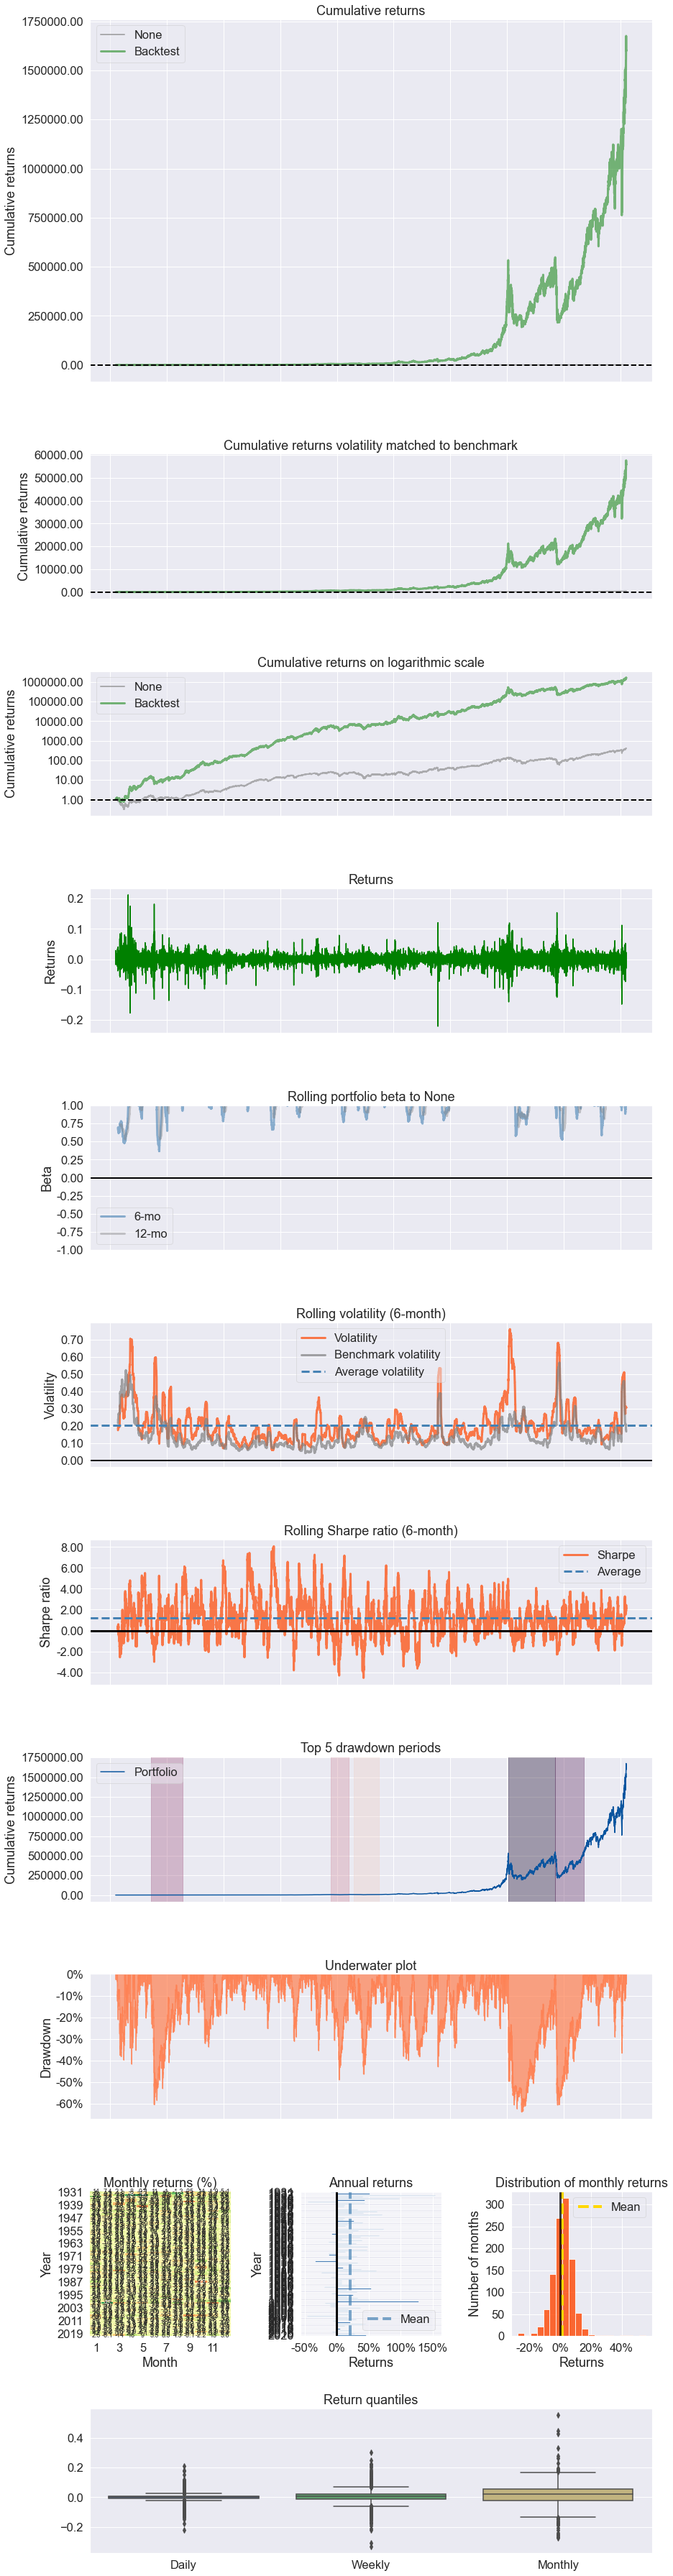

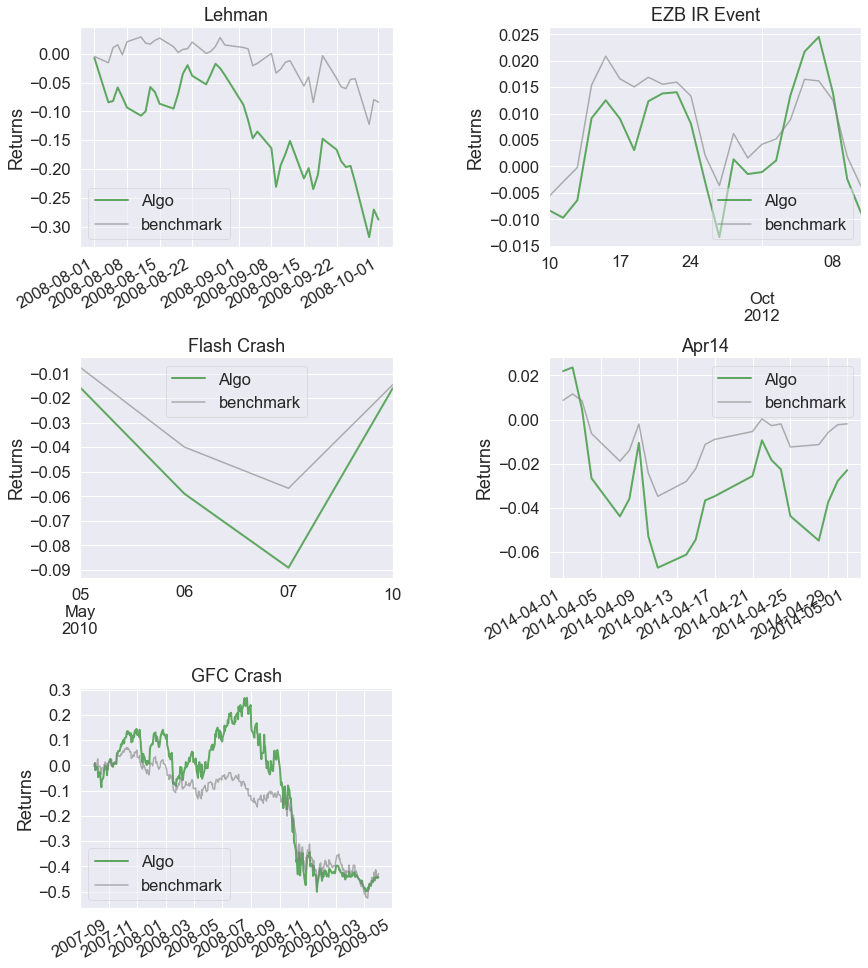

In [98]:
pf.create_full_tear_sheet(winners_excess, benchmark_rets=excess_market)

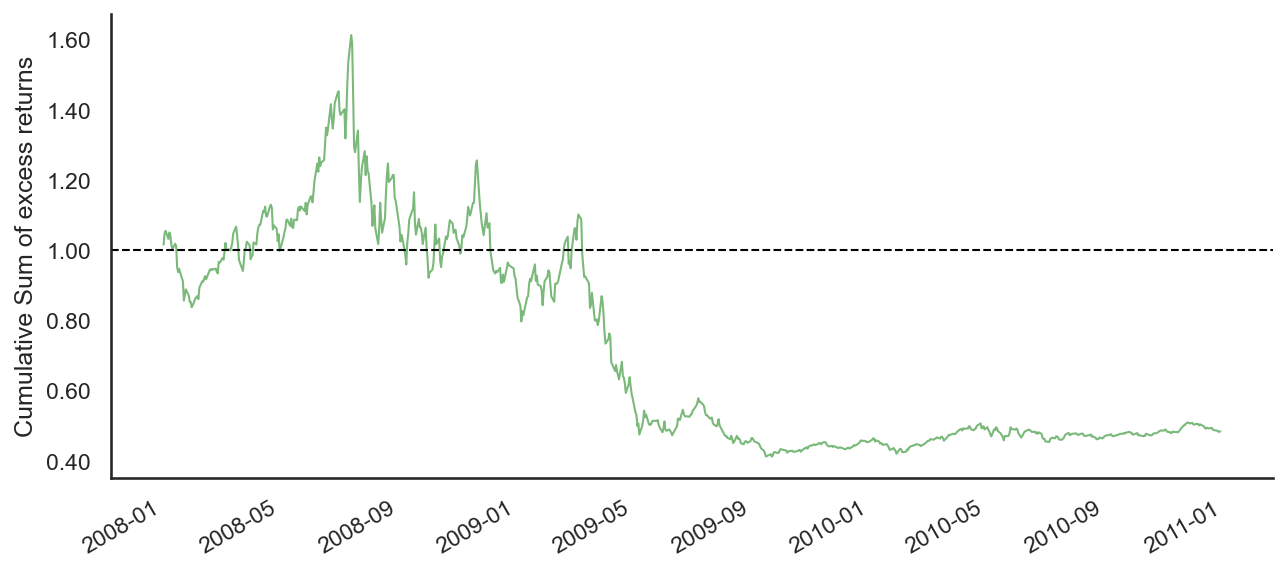

In [141]:
# Returns

# Cumulative Returns
plt.figure(figsize=(10, 10), dpi=150)

plt.subplot(2,1,1)
ax = plt.gca()
#plt.title('Cumulative Sum of Excess Returns', fontsize=12)
pf.plotting.plot_rolling_returns(mom_results, kind='line')
#ax.set_yscale('log')
plt.legend('', edgecolor='white',facecolor='white',  loc = 'upper left',)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel("Cumulative Sum of excess returns")
plt.xlabel("")

for line in ax.get_lines():
    line.set_linewidth(1)

No handles with labels found to put in legend.


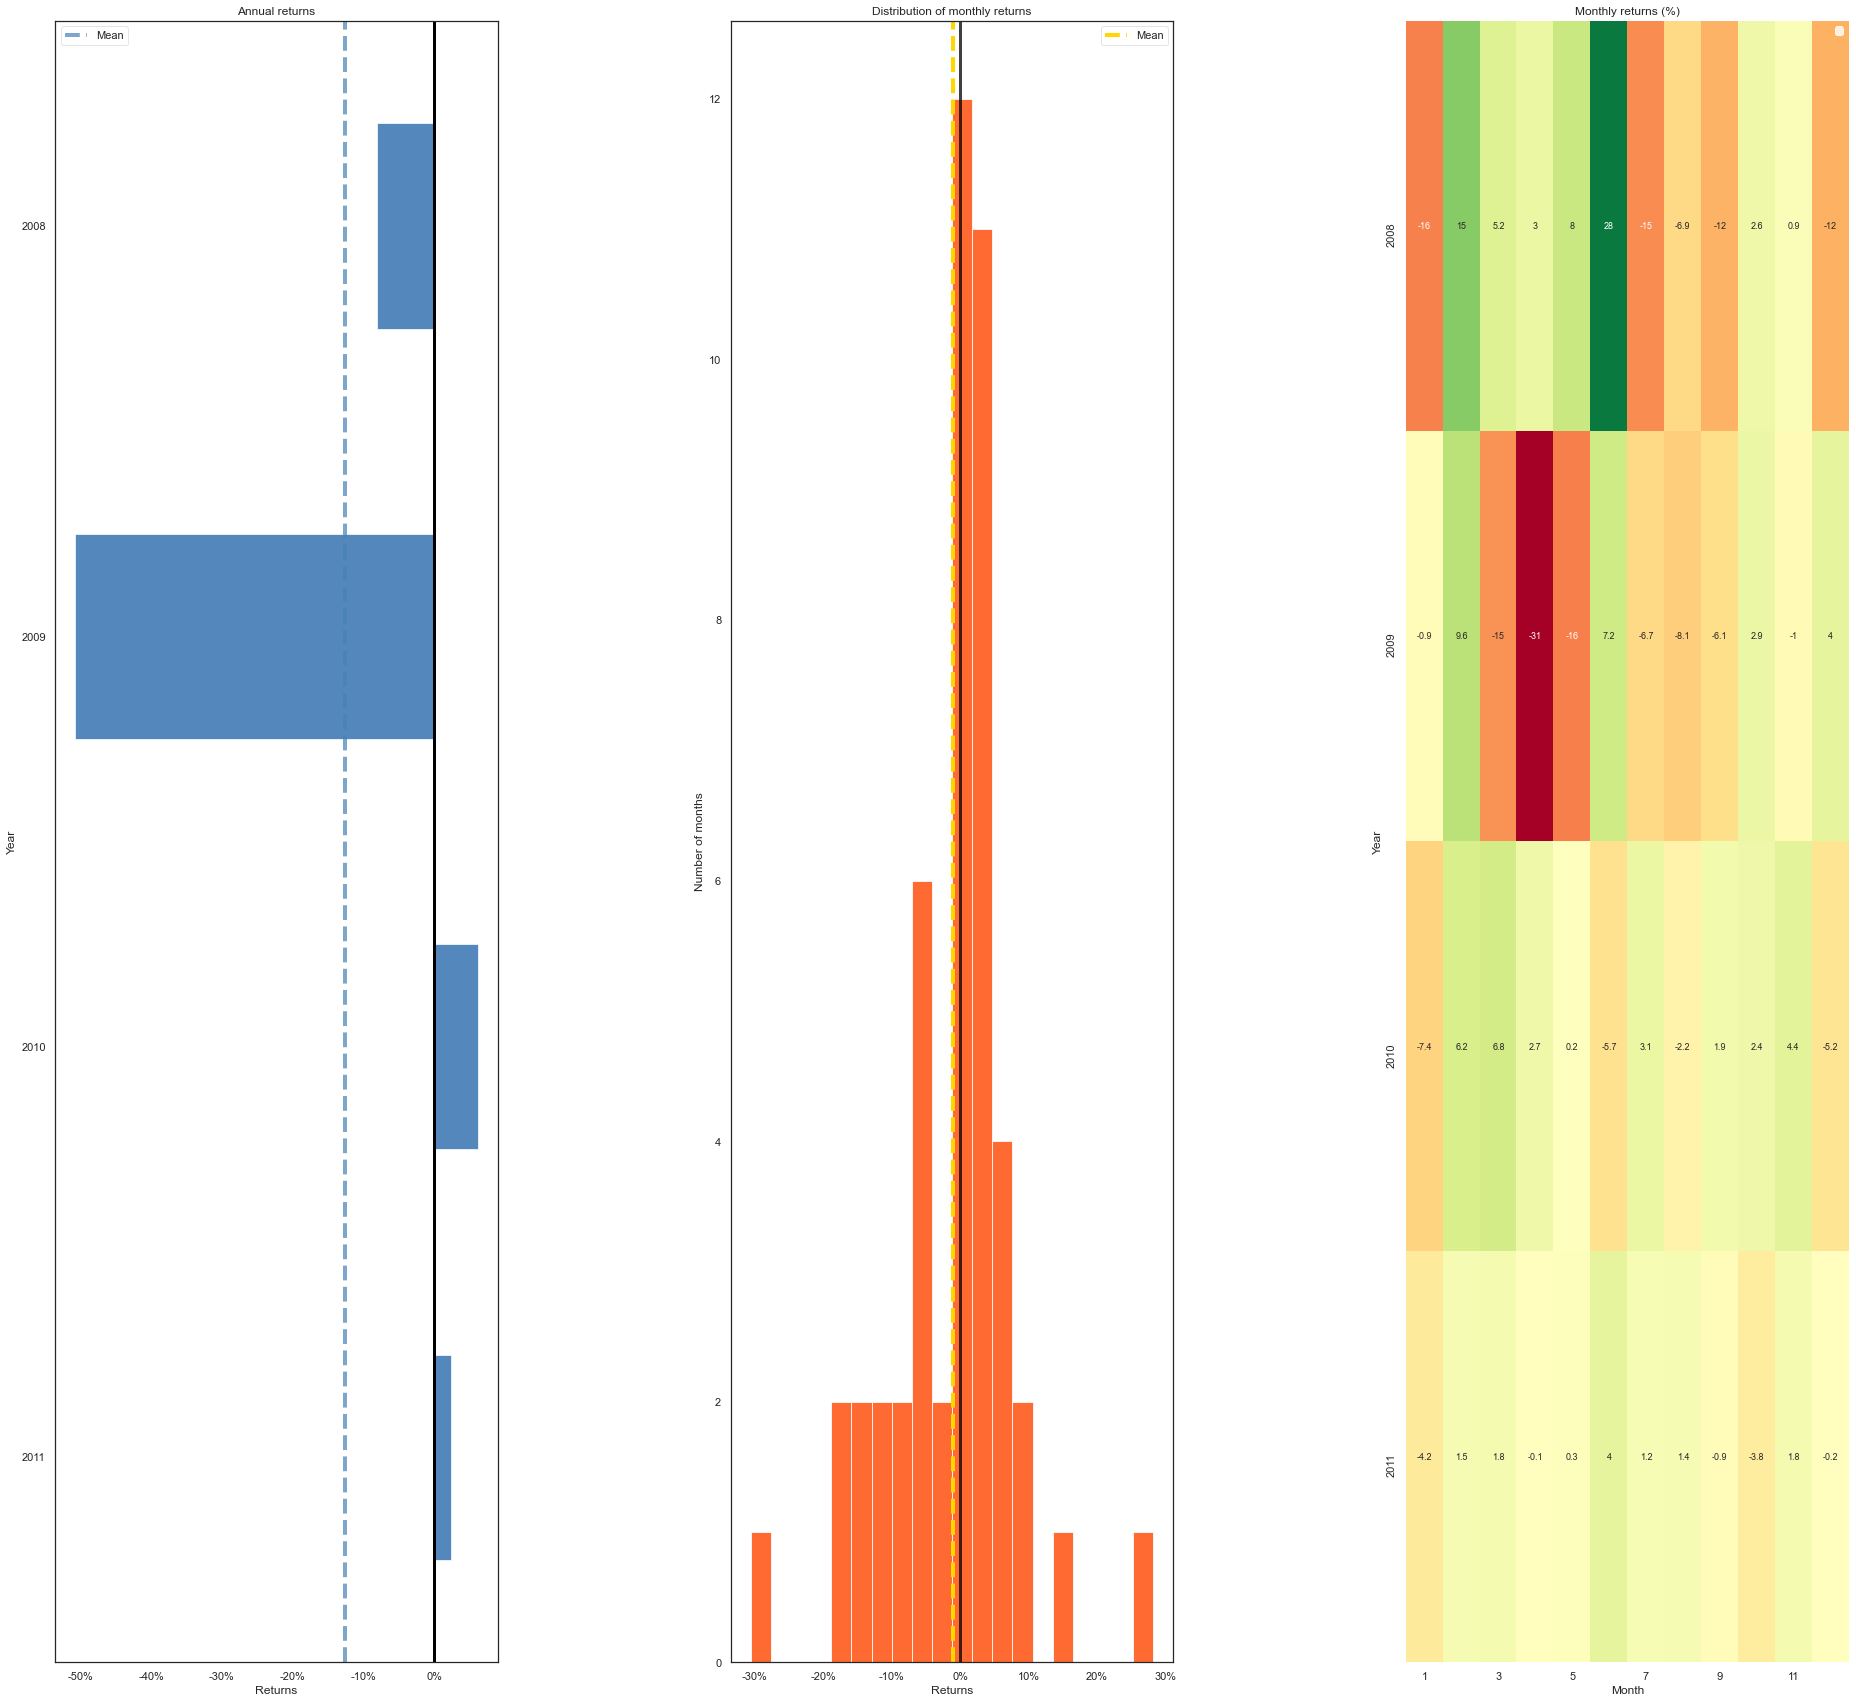

In [116]:
# Distribution of return

fig = plt.figure(1)
plt.subplot(1,3,1)
pf.plot_annual_returns(mom_results)
plt.subplot(1,3,2)
pf.plot_monthly_returns_dist(mom_results)
plt.subplot(1,3,3)
pf.plot_monthly_returns_heatmap(mom_results)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(edgecolor='white',facecolor='white')
plt.tight_layout()
fig.set_size_inches(30,30)

No handles with labels found to put in legend.


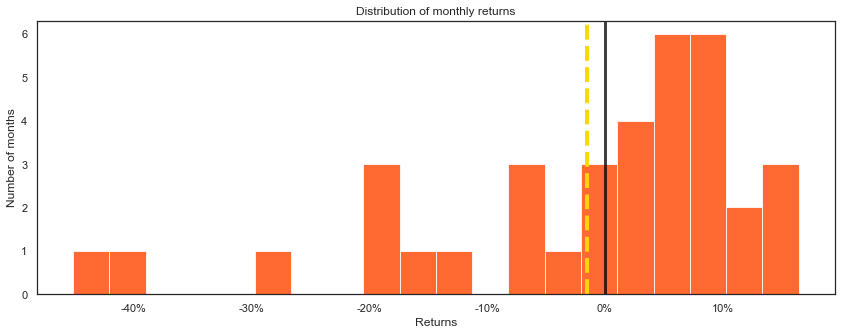

In [57]:
# Distribution of return
fig = plt.figure(1)
plt.subplot(1,3,1)
pf.plot_monthly_returns_dist(mom_results)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(edgecolor='white',facecolor='white')
plt.tight_layout()
fig.set_size_inches(40,5)

No handles with labels found to put in legend.


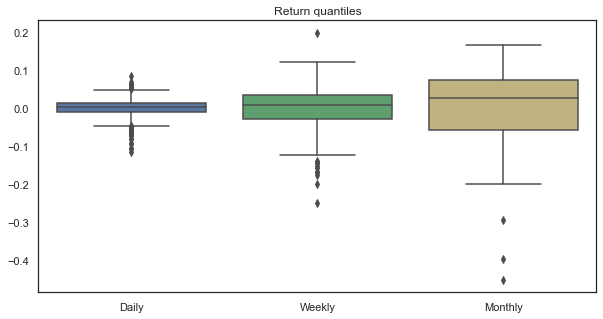

In [58]:
# Return quantiles
plt.figure(figsize=(10,5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(edgecolor='white',facecolor='white')
pf.plot_return_quantiles(mom_results);

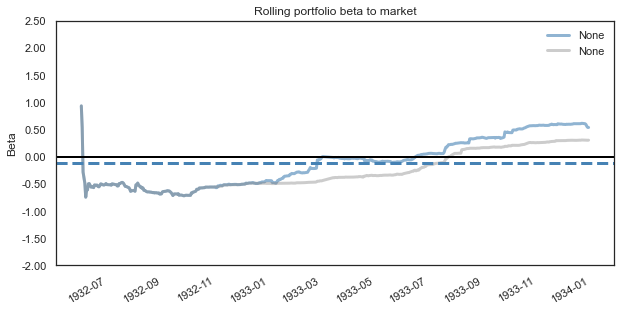

In [59]:
# Rolling beta
plt.figure(figsize=(10,5))
pf.plot_rolling_beta(mom_results, market);
plt.ylim([-2, 2.5])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(edgecolor='white',facecolor='white')

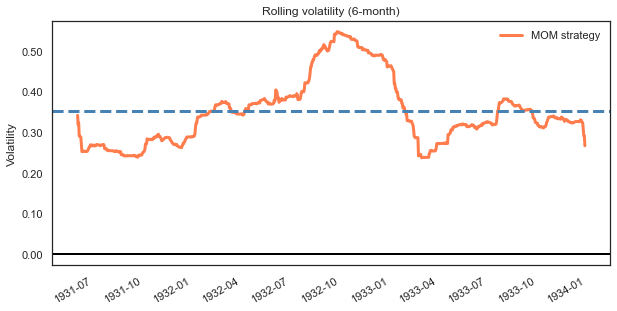

In [60]:
# Rolling vol
plt.figure(figsize=(10,5))
pf.plot_rolling_volatility(mom_results);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(edgecolor='white',facecolor='white')

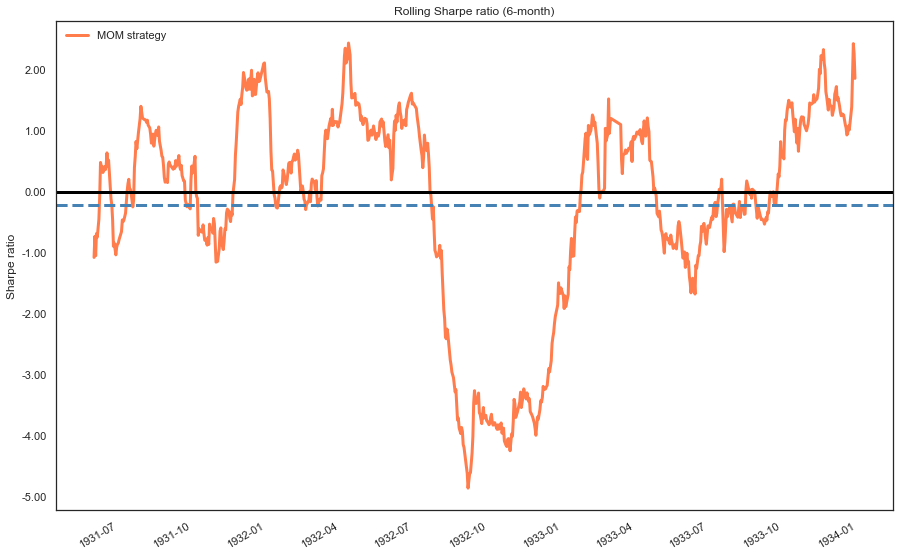

In [61]:
# Rolling sharpe ratio
plt.figure(figsize=(15,10))
pf.plot_rolling_sharpe(mom_results);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(edgecolor='white',facecolor='white')

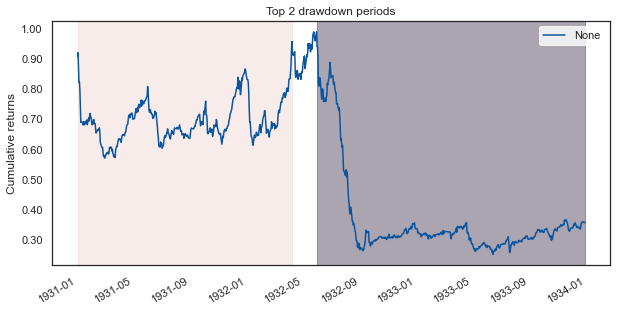

In [62]:
# Drawdown
plt.figure(figsize=(10,5))
pf.plot_drawdown_periods(mom_results);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(edgecolor='white',facecolor='white')

Text(0.5, 0, '')

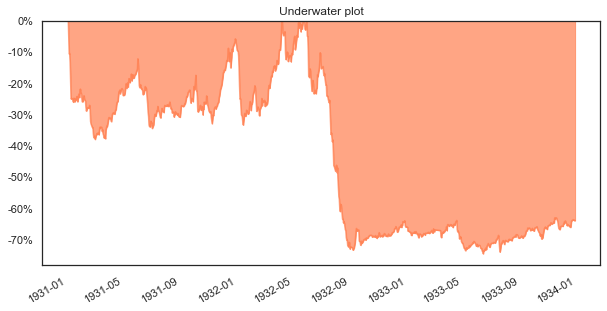

In [63]:
# Drawdown: Underwater plot
plt.figure(figsize=(10,5))
pf.plot_drawdown_underwater(mom_results);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend("", edgecolor='white',facecolor='white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel("")
plt.xlabel("")

In [142]:
print("The Annual Exc. Return of the Winner is: ", empyrical.annual_return(winners_excess)*100)
print('Winner T-stat excess returns:', stats.ttest_1samp(winners_excess, 0.0))
print("The Volatility of the Winner is: ", empyrical.annual_volatility(winners_excess)*100)
print("The alpha of the Winner is: ", empyrical.alpha(winners_excess,excess_market)*100)
print("The Beta of the Winner is: ", empyrical.beta(winners_excess,excess_market))
print("The Sharpe of the Winner is: ", empyrical.sharpe_ratio(winners_excess))
print("The Sortino of the Winner is: ", empyrical.sortino_ratio(winners_excess))
print("MD of the Winner is: ", empyrical.max_drawdown(winners_excess)*100)
print("")

print("The Annual Exc. Return of the Loser is: ", empyrical.annual_return(losers_excess)*100)
print('Losers T-stat excess returns:', stats.ttest_1samp(losers_excess, 0.0))
print("The Volatility of the Loser is: ", empyrical.annual_volatility(losers_excess)*100)
print("The alpha of the Loser is: ", empyrical.alpha(losers_excess,excess_market)*100)
print("The Beta of the Loser is: ", empyrical.beta(losers_excess,excess_market))
print("The Sharpe of the Loser is: ", empyrical.sharpe_ratio(losers_excess))
print("The Sortino of the Loser is: ", empyrical.sortino_ratio(losers_excess))
print("MD of the Loser is: ", empyrical.max_drawdown(losers_excess)*100)

The Annual Exc. Return of the Winner is:  16.50997495145281
Winner T-stat excess returns: Ttest_1sampResult(statistic=7.494315081007349, pvalue=6.899181078753173e-14)
The Volatility of the Winner is:  23.214112327418714
The alpha of the Winner is:  9.17816662591071
The Beta of the Winner is:  1.1663681506324497
The Sharpe of the Winner is:  0.7750600620879865
The Sortino of the Winner is:  1.092801134728947
MD of the Winner is:  -63.89003047156692

The Annual Exc. Return of the Loser is:  5.747456126767436
Losers T-stat excess returns: Ttest_1sampResult(statistic=3.3859035109746984, pvalue=0.0007106015242577847)
The Volatility of the Loser is:  24.421322317126112
The alpha of the Loser is:  -1.0985893450216944
The Beta of the Loser is:  1.222919225593151
The Sharpe of the Loser is:  0.35016923589063026
The Sortino of the Loser is:  0.5225073702387792
MD of the Loser is:  -89.06630403962316


In [152]:
# Estimating alpha and beta
y=winners_excess
X=sm.add_constant(excess_market)
model = sm.OLS(y, X)
results = model.fit()
params = results.params

# Print beta, alpha and t-stats
print("Winners :", results.t_test([1, 0]))

# Estimating alpha and beta
y=losers_excess
X=sm.add_constant(excess_market)
model = sm.OLS(y, X)
results = model.fit()
params = results.params

# Print t-stats
print("Losers :", results.t_test([1, 0]))

Winners :                              Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0003      5e-05      6.970      0.000       0.000       0.000
Losers :                              Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0         -4.384e-05   5.31e-05     -0.826      0.409      -0.000    6.02e-05


In [153]:
# Estimating alpha and beta
y=winners_excess
X=sm.add_constant(losers_excess)
model = sm.OLS(y, X)
results = model.fit()
params = results.params

# Print beta, alpha and t-stats
print("Winners :", results.t_test([1, 0]))

Winners :                              Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0005   7.22e-05      6.973      0.000       0.000       0.001
